In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/spring20/setup_colab.sh -O- | bash

    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/grading.py -O ../grading.py
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/week6_outro/submit.py

    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Selecting previously unselected package xvfb.
(Reading database ... 144429 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.4_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.4) ...
Setting up xvfb (2:1.19.6-1ubuntu4.4) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Starting virtual X frame buffer: Xvfb.


In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Monte-carlo tree search

We'll implement a vanilla MCTS planning and use it to solve some Gym envs.

But before we do that, we first need to modify gym env to allow saving and loading game states to facilitate backtracking.

In [0]:
import gym
from gym.core import Wrapper
from pickle import dumps, loads
from collections import namedtuple

# a container for get_result function below. Works just like tuple, but prettier
ActionResult = namedtuple(
    "action_result", ("snapshot", "observation", "reward", "is_done", "info"))


class WithSnapshots(Wrapper):
    """
    Creates a wrapper that supports saving and loading environemnt states.
    Required for planning algorithms.

    This class will have access to the core environment as self.env, e.g.:
    - self.env.reset()           #reset original env
    - self.env.ale.cloneState()  #make snapshot for atari. load with .restoreState()
    - ...

    You can also use reset() and step() directly for convenience.
    - s = self.reset()                   # same as self.env.reset()
    - s, r, done, _ = self.step(action)  # same as self.env.step(action)
    
    Note that while you may use self.render(), it will spawn a window that cannot be pickled.
    Thus, you will need to call self.close() before pickling will work again.
    """

    def get_snapshot(self, render=False):
        """
        :returns: environment state that can be loaded with load_snapshot 
        Snapshots guarantee same env behaviour each time they are loaded.

        Warning! Snapshots can be arbitrary things (strings, integers, json, tuples)
        Don't count on them being pickle strings when implementing MCTS.

        Developer Note: Make sure the object you return will not be affected by 
        anything that happens to the environment after it's saved.
        You shouldn't, for example, return self.env. 
        In case of doubt, use pickle.dumps or deepcopy.

        """
        if render:
            self.render()  # close popup windows since we can't pickle them
            self.close()
            
        if self.unwrapped.viewer is not None:
            self.unwrapped.viewer.close()
            self.unwrapped.viewer = None
        return dumps(self.env)

    def load_snapshot(self, snapshot, render=False):
        """
        Loads snapshot as current env state.
        Should not change snapshot inplace (in case of doubt, deepcopy).
        """

        assert not hasattr(self, "_monitor") or hasattr(
            self.env, "_monitor"), "can't backtrack while recording"

        if render:
            self.render()  # close popup windows since we can't load into them
            self.close()
        self.env = loads(snapshot)

    def get_result(self, snapshot, action):
        """
        A convenience function that 
        - loads snapshot, 
        - commits action via self.step,
        - and takes snapshot again :)

        :returns: next snapshot, next_observation, reward, is_done, info

        Basically it returns next snapshot and everything that env.step would have returned.
        """

        self.load_snapshot(snapshot)
        s, r, done, info = self.step(action)
        next_snapshot = self.get_snapshot()
        
        return ActionResult(next_snapshot,    #fill in the variables
                            s, 
                            r, done, info)

### Try out snapshots:
Let`s check our wrapper. At first, reset environment and save it, further randomly play some actions and restore our environment from the snapshot. It should be the same as our previous initial state.

In [0]:
# make env
env = WithSnapshots(gym.make("CartPole-v0"))
env.reset()

n_actions = env.action_space.n

initial_state:


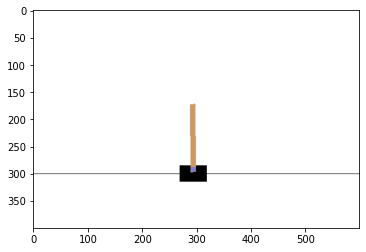

In [5]:
print("initial_state:")
plt.imshow(env.render('rgb_array'))
env.close()

# create first snapshot
snap0 = env.get_snapshot()

Whoops! We died!
final state:


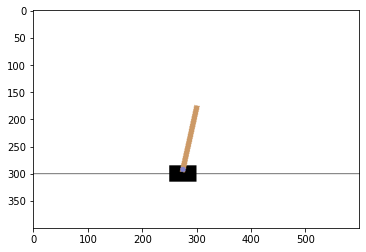

In [6]:
# play without making snapshots (faster)
while True:
    is_done = env.step(env.action_space.sample())[2]
    if is_done:
        print("Whoops! We died!")
        break

print("final state:")
plt.imshow(env.render('rgb_array'))
env.close()



After loading snapshot


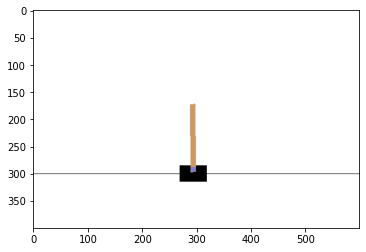

In [7]:
# reload initial state
env.load_snapshot(snap0)

print("\n\nAfter loading snapshot")
plt.imshow(env.render('rgb_array'))
env.close()

In [0]:
# get outcome (snapshot, observation, reward, is_done, info)
res = env.get_result(snap0, env.action_space.sample())

snap1, observation, reward = res[:3]

# second step
res2 = env.get_result(snap1, env.action_space.sample())

# MCTS: Monte-Carlo tree search

![MCTS.png](attachment:MCTS.png)

In this section, we'll implement the vanilla MCTS algorithm with UCB1-based node selection.

$$
\dot{v_a} = v_a + C_n \sqrt{\frac{2 \log {N}}{n_a}}
$$

where: 
- $N$ - number of time-steps so far,
- $n_a$ - times action a is taken
- $C_n$ - balance between exploration-exploitation, for $R \in [0,1]$ $ C_p = \frac{1}{\sqrt{2}}$ 
[paper](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.374.1202&rep=rep1&type=pdf)

We will start by implementing the `Node` class - a simple class that acts like MCTS node and supports some of the MCTS algorithm steps.

This MCTS implementation makes some assumptions about the environment, you can find those _in the notes section at the end of the notebook_.

In [0]:
assert isinstance(env, WithSnapshots)

In [0]:
class Node:
    """ a tree node for MCTS """

    # metadata:
    parent = None  # parent Node
    value_sum = 0.  # sum of state values from all visits (numerator)
    times_visited = 0  # counter of visits (denominator)

    def __init__(self, parent, action,):
        """
        Creates and empty node with no children.
        Does so by commiting an action and recording outcome.

        :param parent: parent Node
        :param action: action to commit from parent Node

        """

        self.parent = parent
        self.action = action
        self.children = set()  # set of child nodes

        # get action outcome and save it
        res = env.get_result(parent.snapshot, action)
        self.snapshot, self.observation, self.immediate_reward, self.is_done, _ = res

    def is_leaf(self):
        return len(self.children) == 0

    def is_root(self):
        return self.parent is None

    def get_mean_value(self):
        return self.value_sum / self.times_visited if self.times_visited != 0 else 0

    def ucb_score(self, scale=10, max_value=1e100):
        """
        Computes ucb1 upper bound using current value and visit counts for node and it's parent.

        :param scale: Multiplies upper bound by that. From hoeffding inequality, assumes reward range to be [0,scale].
        :param max_value: a value that represents infinity (for unvisited nodes)

        """

        if self.times_visited == 0:
            return max_value

        # compute ucb-1 additive component (to be added to mean value)
        # hint: you can use self.parent.times_visited for N times node was considered,
        # and self.times_visited for n times it was visited

        U = np.sqrt(2*np.log(self.parent.times_visited)/self.times_visited) # <YOUR CODE>

        return self.get_mean_value() + scale*U

    # MCTS steps

    def select_best_leaf(self):
        """
        Picks the leaf with highest priority to expand
        Does so by recursively picking nodes with best UCB-1 score until it reaches the leaf.

        """
        if self.is_leaf():
            return self

        children = list(self.children)
        
        best_child = children[np.argmax([child.ucb_score() for child in children])] # <YOUR CODE: select best child node in terms of node.ucb_score()>

        return best_child.select_best_leaf()

    def expand(self):
        """
        Expands the current node by creating all possible child nodes.
        Then returns one of those children.
        """

        assert not self.is_done, "can't expand from terminal state"

        for action in range(n_actions):
            self.children.add(Node(self, action))

        return self.select_best_leaf()

    def rollout(self, t_max=10**4):
        """
        Play the game from this state to the end (done) or for t_max steps.

        On each step, pick action at random (hint: env.action_space.sample()).

        Compute sum of rewards from current state till 
        Note 1: use env.action_space.sample() for random action
        Note 2: if node is terminal (self.is_done is True), just return 0

        """

        # set env into the appropriate state
        env.load_snapshot(self.snapshot)
        obs = self.observation
        is_done = self.is_done

        # <YOUR CODE: perform rollout and compute reward>
        rollout_reward = 0
        snapshot = self.snapshot
        while not is_done and t_max > 0:
            snapshot, s, r, is_done, _ = env.get_result(snapshot, env.action_space.sample())
            rollout_reward += r
            t_max -= 1

        return rollout_reward

    def propagate(self, child_value):
        """
        Uses child value (sum of rewards) to update parents recursively.
        """
        # compute node value
        my_value = self.immediate_reward + child_value

        # update value_sum and times_visited
        self.value_sum += my_value
        self.times_visited += 1

        # propagate upwards
        if not self.is_root():
            self.parent.propagate(my_value)

    def safe_delete(self):
        """safe delete to prevent memory leak in some python versions"""
        del self.parent
        for child in self.children:
            child.safe_delete()
            del child

In [0]:
class Root(Node):
    def __init__(self, snapshot, observation):
        """
        creates special node that acts like tree root
        :snapshot: snapshot (from env.get_snapshot) to start planning from
        :observation: last environment observation
        """

        self.parent = self.action = None
        self.children = set()  # set of child nodes

        # root: load snapshot and observation
        self.snapshot = snapshot
        self.observation = observation
        self.immediate_reward = 0
        self.is_done = False

    @staticmethod
    def from_node(node):
        """initializes node as root"""
        root = Root(node.snapshot, node.observation)
        # copy data
        copied_fields = ["value_sum", "times_visited", "children", "is_done"]
        for field in copied_fields:
            setattr(root, field, getattr(node, field))
        return root

## Main MCTS loop

With all we implemented, MCTS boils down to a trivial piece of code.

In [0]:
def plan_mcts(root, n_iters=10):
    """
    builds tree with monte-carlo tree search for n_iters iterations
    :param root: tree node to plan from
    :param n_iters: how many select-expand-simulate-propagete loops to make
    """
    for _ in range(n_iters):

        node = root.select_best_leaf()# <YOUR CODE: select best leaf>

        if node.is_done:
            node.propagate(0)

        else:  # node is not terminal
            #<YOUR CODE: expand-simulate-propagate loop>
            next_node = node.expand()
            rollout_reward = next_node.rollout()
            node.propagate(rollout_reward)

## Plan and execute
In this section, we use the MCTS implementation to find optimal policy.

In [0]:
env = WithSnapshots(gym.make("CartPole-v0"))
root_observation = env.reset()
root_snapshot = env.get_snapshot()
root = Root(root_snapshot, root_observation)

In [0]:
# plan from root:
plan_mcts(root, n_iters=1500)

In [0]:
# import copy
# saved_root = copy.deepcopy(root)
# root = saved_root

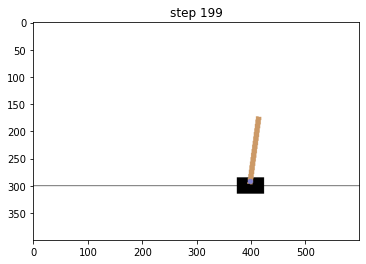

Finished with reward =  200.0


In [33]:
from IPython.display import clear_output
from itertools import count
from gym.wrappers import Monitor

total_reward = 0  # sum of rewards
test_env = loads(root_snapshot)  # env used to show progress

for i in count():

    # get best child
    children = list(root.children)
    best_child = children[np.argmax([child.get_mean_value() for child in children])]
    # best_child = root.select_best_leaf()# <YOUR CODE: select child with highest mean reward>

    # take action
    s, r, done, _ = test_env.step(best_child.action)

    # show image
    clear_output(True)
    plt.title("step %i" % i)
    plt.imshow(test_env.render('rgb_array'))
    plt.show()

    total_reward += r
    if done:
        print("Finished with reward = ", total_reward)
        break

    # discard unrealized part of the tree [because not every child matters :(]
    for child in root.children:
        if child != best_child:
            child.safe_delete()

    # declare best child a new root
    root = Root.from_node(best_child)

    # assert not root.is_leaf(
    # ), "We ran out of tree! Need more planning! Try growing tree right inside the loop."

    # you may want to expand tree here
    # <YOUR CODE>
    if root.is_leaf():
        plan_mcts(root,n_iters=10)

### Submit to Coursera

In [34]:
from submit import submit_mcts

submit_mcts(total_reward, "ng.hieu100@gmail.com", "VMPKaORqmHYkbOFx")

Submitted to Coursera platform. See results on assignment page!


## More stuff

There's a few things you might want to try if you want to dig deeper:

### Node selection and expansion

"Analyze this" assignment

UCB-1 is a weak bound as it relies on a very general bounds (Hoeffding Inequality, to be exact). 
* Try playing with alpha. The theoretically optimal alpha for CartPole is 200 (max reward). 
* Use using a different exploration strategy (bayesian UCB, for example)
* Expand not all but several random actions per `expand` call. See __the notes below__ for details.

The goal is to find out what gives the optimal performance for `CartPole-v0` for different time budgets (i.e. different n_iter in plan_mcts.

Evaluate your results on `Acrobot-v1` - do the results change and if so, how can you explain it?


### Atari-RAM

"Build this" assignment

Apply MCTS to play atari games. In particular, let's start with ```gym.make("MsPacman-ramDeterministic-v0")```.

This requires two things:
* Slightly modify WithSnapshots wrapper to work with atari.

 * Atari has a special interface for snapshots:
   ```   
   snapshot = self.env.ale.cloneState()
   ...
   self.env.ale.restoreState(snapshot)
   ```
 * Try it on the env above to make sure it does what you told it to.
 
* Run MCTS on the game above. 
 * Start with small tree size to speed-up computations
 * You will probably want to rollout for 10-100 steps (t_max) for starters
 * Consider using discounted rewards (see __notes at the end__)
 * Try a better rollout policy
 
 
### Integrate learning into planning

Planning on each iteration is a costly thing to do. You can speed things up drastically if you train a classifier to predict which action will turn out to be best according to MCTS.

To do so, just record which action did the MCTS agent take on each step and fit something to [state, mcts_optimal_action]
* You can also use optimal actions from discarded states to get more (dirty) samples. Just don't forget to fine-tune without them.
* It's also worth a try to use P(best_action|state) from your model to select best nodes in addition to UCB
* If your model is lightweight enough, try using it as a rollout policy.

While CartPole is glorious enough, try expanding this to ```gym.make("MsPacmanDeterministic-v0")```
* See previous section on how to wrap atari

* Also consider what [AlphaGo Zero](https://deepmind.com/blog/alphago-zero-learning-scratch/) did in this area.

### Integrate planning into learning 
_(this will likely take long time, better consider this as side project when all other deadlines are met)_

Incorporate planning into the agent architecture. The goal is to implement [Value Iteration Networks](https://arxiv.org/abs/1602.02867).

Remember [week5 assignment](https://github.com/yandexdataschool/Practical_RL/blob/coursera/week5_policy_based/practice_a3c.ipynb)? You will need to switch it into a maze-like game, like MsPacman, and implement a special layer that performs value iteration-like update to a recurrent memory. This can be implemented the same way you did in the POMDP assignment.

## Notes


#### Assumptions

The full list of assumptions is
* __Finite actions__ - we enumerate all actions in `expand`
* __Episodic (finite) MDP__ - while technically it works for infinite mdp, we rollout for $ 10^4$ steps. If you are knowingly infinite, please adjust `t_max` to something more reasonable.
* __No discounted rewards__ - we assume $\gamma=1$. If that isn't the case, you only need to change two lines in `rollout` and use `my_R = r + gamma*child_R` for `propagate`
* __pickleable env__ - won't work if e.g. your env is connected to a web-browser surfing the internet. For custom envs, you may need to modify get_snapshot/load_snapshot from `WithSnapshots`.

#### On `get_best_leaf` and `expand` functions

This MCTS implementation only selects leaf nodes for expansion.
This doesn't break things down because `expand` adds all possible actions. Hence, all non-leaf nodes are by design fully expanded and shouldn't be selected.

If you want to only add a few random action on each expand, you will also have to modify `get_best_leaf` to consider returning non-leafs.

#### Rollout policy

We use a simple uniform policy for rollouts. This introduces a negative bias to good situations that can be messed up completely with random bad action. As a simple example, if you tend to rollout with uniform policy, you better don't use sharp knives and walk near cliffs.

You can improve that by integrating a reinforcement _learning_ algorithm with a computationally light agent. You can even train this agent on optimal policy found by the tree search.

#### Contributions
* Reusing some code from 5vision [solution for deephack.RL](https://github.com/5vision/uct_atari), code by Mikhail Pavlov
* Using some code from [this gist](https://gist.github.com/blole/dfebbec182e6b72ec16b66cc7e331110)